# Script to explore the hypyp package for the analysis of hyperscanning datasets

In [5]:
# Import relevant packages

# Core
import io
from copy import copy
from collections import OrderedDict
import requests

# Useful packages
import numpy as np
import scipy
import mne

#Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from hypyp.ext.mpl3d import glm --- no extension .ext?? 
#from hypyp.ext.mpl3d.mesh import Mesh
#from hypyp.ext.mpl3d.camera import Camera

# hypyp
from hypyp import prep # need pip install https://api.github.com/repos/autoreject/autoreject/zipball/master
from hypyp import analyses
from hypyp import stats
from hypyp import viz

C:\Users\ymfonken\Miniconda3\lib\site-packages\astropy\config\configuration.py:557: ConfigurationMissingWarning: Configuration defaults will be used due to FileNotFoundError:2 on None
  warn(ConfigurationMissingWarning(msg))


## Set parameters

In [8]:
freq_bands = {'Theta': [4, 7],
              'Alpha-Low': [7.5, 11],
              'Alpha-High': [11.5, 13],
              'Beta': [13.5, 29.5],
              'Gamma': [30, 48]}

freq_bands = OrderedDict(freq_bands)

## Load data

In [9]:
# load example dataset -- epochs MNE format in fif 
URL_TEMPLATE = "https://github.com/ppsp-team/HyPyP/blob/master/data/participant{}-epo.fif?raw=true"

def get_data(idx):
    return io.BytesIO(requests.get(URL_TEMPLATE.format(idx)).content)

epo1 = mne.read_epochs(
    get_data(1),
    preload=True,
) 

epo2 = mne.read_epochs(
    get_data(2),
    preload=True,
)

Reading File-like <_io.BytesIO object at 0x0000021833D83770> ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
260 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading File-like <_io.BytesIO object at 0x000002183A84CF90> ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
36 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [10]:
# equalize epochs -- in this example the two datasets weren't meant to be used for hyperscanning, 
# so they have an unequal number of epochs (trials). This can be corrected with the following function. 
# NOTE: not sure how this makes sure that the epochs are indeed the same epochs across the two subjects?
# We shouldn't need this with our analysis. 

mne.epochs.equalize_epoch_counts([epo1, epo2])

# specify sampling rate
sampling_rate = epo1.info['sfreq'] #Hz


Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

In [12]:
# Look at the content of the dataset:
epo1.info

<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F8, F3, F4, Fz, FT9, FT10, FC5, FC1, FC2, FC6, T7, ...
 chs: 31 EEG
 custom_ref_applied: True
 dig: 34 items (3 Cardinal, 31 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 50.0 Hz
 meas_date: 2015-07-13 17:07:33 UTC
 meas_id: 4 items (dict)
 nchan: 31
 projs: []
 sfreq: 500.0 Hz
>

## Preprocess data

In [13]:
# first do ICA - this is a 31 channel EEG, so I'm guessing that's why they chose 15 components (31 max possible, but most will have noise)
icas = prep.ICA_fit([epo1, epo2],
                    n_components=15,
                    method='infomax',
                    fit_params=dict(extended=True),
                    random_state=42)

Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.00010129807784293706}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 3.9s.
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 3.8s.
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 4.747409473367548e-05}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 4.8s.
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 4.5s.


In [15]:
prep.ICA_choice_comp?

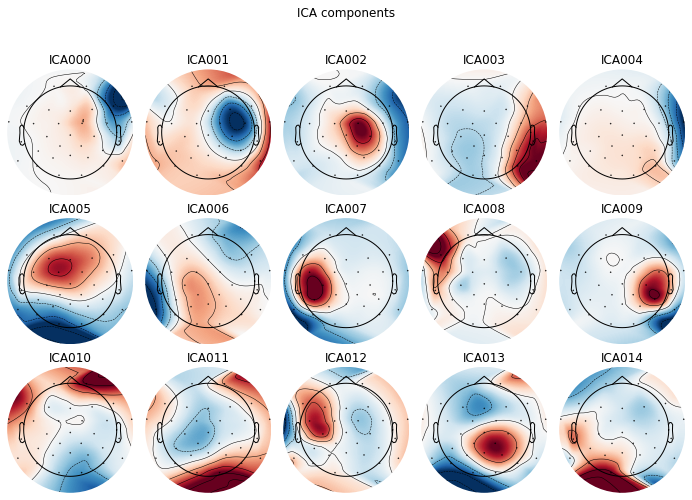

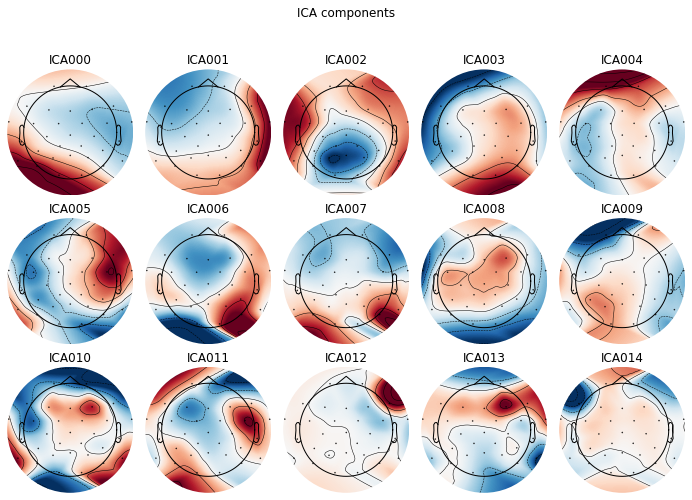

Which participant ICA do you want to use as a template for artifact rejection? Index begins at zero. If you do not want to apply ICA on your data, enter nothing.1
Which IC do you want to use as a template? Index begins at zero. If you do not want to apply ICA on your data, enter nothing.4


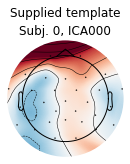

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


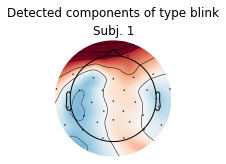

[{'blink': []}, {'blink': [4]}]
Transforming to ICA space (15 components)
Zeroing out 0 ICA components
Transforming to ICA space (15 components)
Zeroing out 1 ICA component


In [17]:
# Following plots IC's, let's you choose which components are artifactual, 
# and removes these from the data in epochs
# IMPORTANT: the software let's you choose one subject to pick the bad components for, 
# and applies the same selection to the second subject (presumably by correlating the 
# IC weights?). This feature may not work with parent-baby hyperscanning
cleaned_epochs_ICA = prep.ICA_choice_comp(icas, [epo1, epo2])

# Also, the above may not be how we want to apply ICA. It's better to correlate the IC's with 
# the EOG channels to pull out eye-movement IC's. 
# Note that the IC's below do not show clear eye-movement topographies. 
# Subject 2 has a clear eye-blink IC (#4), but Subject 1 doesn't. IC9 in subject 2 may be eye-movements as well

### It seems like you can only select 1 component. With eye-movements there should be at least two (maybe run this script twice?)
### If you choose subject 2, IC 4, it cannot find an equivalent in the first subject (I can't either so that seems about right). 


## Autoreject epochs
#### Looks like there is a function that 1) automatically rejects bad trials, 2) automatically rejects
#### bad channels, 3) interpolates bad channels, usually from surrounding channels
#### Important: such interpolated channels may become a problem in connectivity analysis later on, 
#### consider not interpolating?

In [25]:
cleaned_epochs_AR, dic_AR = prep.AR_local(cleaned_epochs_ICA)
                                          #strategy="union",
                                          #threshold=50.0,
                                          #verbose=True

# I get an error on keyword 'strategy', help function is of no use

Dropped 0 epochs: 
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 8 epochs: 0, 2, 3, 4, 5, 6, 9, 20


In [26]:
# Here they separate the two datasets again for some reason
preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]

## Analyzing data



In [27]:
# They use a welch filter, I like complex morlets generally, but there may be something to say 
# for Welch specifically for connectivity analyses

psd1 = analyses.pow(preproc_S1, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
psd2 = analyses.pow(preproc_S2, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
data_psd = np.array([psd1.psd, psd2.psd])

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


In [29]:
# Extract analytic signal (probably a wrapper for MNE?)
data_inter = np.array([preproc_S1, preproc_S2])
result_intra = []
complex_signal = analyses.compute_freq_bands(data_inter, sampling_rate,
                                             freq_bands)

# this gives a filter length error. This should be looked into, as filter length can make a huge difference
# in runtime and may give edge effects

C:\Users\ymfonken\Miniconda3\lib\site-packages\hypyp\analyses.py:407: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
C:\Users\ymfonken\Miniconda3\lib\site-packages\hypyp\analyses.py:407: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
C:\Users\ymfonken\Miniconda3\lib\site-packages\hypyp\analyses.py:407: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
C:\Users\ymfonken\Miniconda3\lib\site-packages\hypyp\analyses.py:407: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter len